<a href="https://colab.research.google.com/github/TzurV/TestMe/blob/master/pytorch_nn_tutorial_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://pytorch.org/tutorials/beginner/nn_tutorial.html
#=========================================================

from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip
from matplotlib import pyplot
import numpy as np

# This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        

In [ ]:
#https://ipython.readthedocs.io/en/stable/interactive/magics.html


#Print all interactive variables, with some minimal formatting.
print(" --- %who ----")
%who
# Return a sorted list of all interactive variables.
print(" --- %who_ls ----")
%who_ls
# Like %who, but gives some extra information about each variable.
print(" --- %whos ----")
%whos

# https://medium.com/@chrieke/jupyter-tips-and-tricks-994fdddb2057
# stops and interactive python command line runs !
#%debug

 --- %who ----
DATA_PATH	 FILENAME	 PATH	 Path	 URL	 content	 f	 gzip	 np	 
pickle	 pyplot	 requests	 x_train	 x_valid	 y_train	 y_valid	 
 --- %who_ls ----
 --- %whos ----
Variable    Type         Data/Info
----------------------------------
DATA_PATH   PosixPath    data
FILENAME    str          mnist.pkl.gz
PATH        PosixPath    data/mnist
Path        type         <class 'pathlib.Path'>
URL         str          http://deeplearning.net/data/mnist/
content     bytes        b'\x1f\x8b\x08\x08\x14UOK<...>\x84\x1b\x04o\xd6(\x1e\r'
f           GzipFile     <gzip on 0x7f32465ff438>
gzip        module       <module 'gzip' from '/usr/lib/python3.6/gzip.py'>
np          module       <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
pickle      module       <module 'pickle' from '/u<...>lib/python3.6/pickle.py'>
pyplot      module       <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
requests    module       <module 'requests' from '<...>es/requests/__init__.py'>
x_train     nd

(50000, 784)


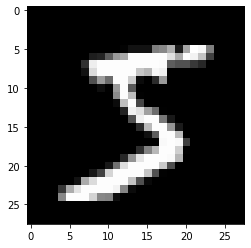

In [ ]:
#Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)


In [ ]:
#PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

import torch
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [8]:
import math

# We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n)).
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
    
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

yb = y_train[0:bs]
print(loss_func(preds, yb))



tensor([-2.2628, -2.3141, -2.3516, -2.1881, -2.1966, -2.6931, -2.3251, -2.3796,
        -2.2372, -2.1736], grad_fn=<SelectBackward>) torch.Size([64, 10])
tensor(2.3135, grad_fn=<NegBackward>)


In [12]:
## Using torch.nn.functional ===

import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

# Note that we no longer call log_softmax in the model function. 
# Let’s confirm that our loss and accuracy are the same as before:

print(loss_func(model(xb), yb), accuracy(model(xb), yb))




tensor(2.2864, grad_fn=<NllLossBackward>) tensor(0.0625)


In [13]:
#@Refactor using nn.Module

from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

#we first have to instantiate our model:
model = Mnist_Logistic()

print("1> ", loss_func(model(xb), yb))

# for our training loop
# we can take advantage of model.parameters() and model.zero_grad() 
# (which are both defined by PyTorch for nn.Module) 
# to make those steps more concise and less prone to the error 
# of forgetting some of our parameters, particularly if we had a more 
# complicated model:


lr = 0.5  # learning rate
epochs = 4  # how many epochs to train for


from torch import optim

#We’ll define a little function to create our model and optimizer so we can reuse it in the future.
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print("2> ", loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print("3> ", loss_func(model(xb), yb))

1>  tensor(2.4465, grad_fn=<NllLossBackward>)
2>  tensor(2.5491, grad_fn=<NllLossBackward>)
3>  tensor(0.0657, grad_fn=<NllLossBackward>)


# Refactor using Dataset

[link text](https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-dataset)


PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python’s standard len function) and a __getitem__ function as a way of indexing into it. This tutorial walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of Dataset.

PyTorch’s TensorDataset is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.


In [16]:
from torch.utils.data import TensorDataset


print(type(x_train), x_train.dim)

# Both x_train and y_train can be combined in a single TensorDataset, 
# which will be easier to iterate over and slice.
# https://pytorch.org/docs/stable/data.html


train_ds = TensorDataset(x_train, y_train)
print(type(train_ds))


model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

<class 'torch.Tensor'> <built-in method dim of Tensor object at 0x7f324592bab0>
<class 'torch.utils.data.dataset.TensorDataset'>
tensor(0.0654, grad_fn=<NllLossBackward>)


In [18]:
# Pytorch’s DataLoader is responsible for managing batches.

# Pytorch’s DataLoader is responsible for managing batches. 
# You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches. 
# Rather than having to use train_ds[i*bs : i*bs+bs], the DataLoader gives us each minibatch automatically.

from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)


# Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))


# Add validation
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

# We will calculate and print the validation loss at the end of each epoch.
# Note that we always call model.train() before training, and model.eval() before inference, 
# because these are used by layers such as nn.BatchNorm2d and nn.Dropout to 
# ensure appropriate behaviour for these different phases.

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    # set model in evaluation mode
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

tensor(0.0541, grad_fn=<NllLossBackward>)
0 tensor(0.3084)
1 tensor(0.2926)
2 tensor(0.2769)
3 tensor(0.2902)


In [20]:
# Create fit() and get_data()
# https://pytorch.org/tutorials/beginner/nn_tutorial.html#create-fit-and-get-data

# We’ll now do a little refactoring of our own. 
# Since we go through a similar process twice of calculating the loss for both the 
# training set and the validation set, let’s make that into its own function, 
# loss_batch, which computes the loss for one batch.

import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)



def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)    


def get_data(train_ds, valid_ds, bs):
    """ get_data returns dataloaders for the training and validation sets.
    """
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


# ----------------------------------------------------------------------------
# Now, our whole process of obtaining the data loaders and fitting the model 
# can be run in 3 lines of code:

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.36449238107204435
1 0.28494877679944036
2 0.3035925836145878
3 0.2965792589187622


In [21]:
# Switch to CNN
# https://pytorch.org/tutorials/beginner/nn_tutorial.html#switch-to-cnn

# previously it was defined in as 
#class Mnist_Logistic(nn.Module):
#    def __init__(self):
#        super().__init__()
#        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
#        self.bias = nn.Parameter(torch.zeros(10))
#
#    def forward(self, xb):
#        return xb @ self.weights + self.bias

# define the model 
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

# Momentum is a variation on stochastic gradient descent that takes previous updates 
# into account as well and generally leads to faster training.

model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.33695877437591554
1 0.25309643216133115
2 0.21719727429151536
3 0.1907979161977768


In [22]:
# nn.Sequential
#  https://pytorch.org/tutorials/beginner/nn_tutorial.html#nn-sequential
# A Sequential object runs each of the modules contained within it, in a sequential manner. 
# This is a simpler way of writing our neural network.

#PyTorch doesn’t have a view layer, and we need to create one for our network. 
# Lambda will create a layer that we can then use when defining a network with Sequential. 

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

# The model created with Sequential is simply:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.35414660758972166
1 0.2861324119567871
2 0.19552086279392242
3 0.21421364369392396


In [23]:
print(torch.cuda.is_available())


False
